In [2]:
import sys; sys.path.append('..') # add project root to the python path

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.toy_text import CliffWalkingEnv

from src.part2.temporal_difference import SARSA, QLearner
from src.common.grid_visualization import visualize_value_function, visualize_policy

np.random.seed(0)

In [4]:
import gym
gym.__file__

'/home/yoonju/anaconda3/envs/RL101/lib/python3.9/site-packages/gym/__init__.py'

## SARSA와 Q-Learning

SARSA 와 Q-learning 모두 TD기법을 활용하여 최적정책을 찾는 방법이었습니다. 하지만 이 두가지 알고리즘은 각각 on-policy 와 off-policy 라는 본질적인 차이를 가지고 있었던것 기억하시나요?

> 1. on-policy 기법은 현재 평가하는 정책 $\pi(a|s)$ 와 행동 정책 $\mu(a|s)$이 동일
> 2. off-policy 기법은 현재 평가하는 정책 $\pi(a|s)$ 와 행동 정책 $\mu(a|s)$이 다름

즉 `Q-learning` 알고리즘은 환경으로부터 데이터를 얻기위해 사용했던 $\epsilon$-탐욕적 정책 대신, 알고리즘의 성능을 평가하기 위해서, 현재 추산된 $Q(s,a)$로 탐욕적 정책을 사용할수 있다는 것입니다. 이번 실습에서는 새로운 환경에서 `SARSA`의 $\epsilon$-탐욕적 정책과 `Q-learning`을 통해서 구한 $Q(s,a)$에 탐욕적 정책의 차이를 확인해볼까요?

## `CliffWalkingEnv` 
 
이번 실습에서는 새로운 환경인 `CliffWalkingEnv`를 사용하겠습니다.

In [5]:
cliff_env = CliffWalkingEnv()

In [6]:
cliff_env.render_mode='ansi' #'human' 으로 바꾸면 UI로 보여줌
cliff_env.reset()

(36, {'prob': 1})

## `CliffWalkingEnv` 돌아보기

`CliffWalkingEnv` 는 일종의 그리드 환경입니다. 
1. 상태공간 $\cal{S}$은 가로로 12칸 세로로 4칸인 격자 공간으로서, 총 48개의 상태 $s$ 가 존재합니다. <br>
2. 행동 공간 $\cal{A}$은 모든 상태 $s$에 대해서 `'상','우','하','좌'`입니다. 즉 4개의 행동이 존재합니다. <br>
3. 초기상태 $s_0$은 항상 좌측 하단 셀로 고정되어 있습니다. 종결상태는 가장 오른쪽 하단입니다. 절벽상태 $c$는 초기상태와 종결상태를 제외한 모든 최하단 셀들입니다. <br>
4. 보상함수는 매 이동마다 `-1` 이며 추가적으로 절벽 $c$ 에 도달할 때마다 `-100`을 받습니다. <br>
5. 만약 절벽상태 $c$ 에 도달하면 다시 초기상태 $s_0$로 되돌아가게 됩니다. <br>

In [7]:
print(cliff_env.render())

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T




## SARSA, Q-Learning 에이전트 초기화하기

두개의 에이전트를 모두 동일한 파라미터로 초기화 하였습니다. $\epsilon$ 의 경우 `적당하게` 낮은 0.1 정도로 설정해줍니다.

In [8]:
cliff_env.nS, cliff_env.nA

(48, 4)

In [9]:
sarsa_agent = SARSA(gamma=.9,
                    lr=1e-1,
                    num_states=cliff_env.nS,
                    num_actions=cliff_env.nA,
                    epsilon=0.1)

q_agent = QLearner(gamma=.9,
                   lr=1e-1,
                   num_states=cliff_env.nS,
                   num_actions=cliff_env.nA,
                   epsilon=0.1)

`env/toy_text/cliffwalking.py' 파일에서 수정
```
    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.render_mode == "human":
            self.render()
        return (int(s), r, t, {"prob": p})
```

## 실험진행에 사용할 코드

두개의 에이전트를 주어진 환경과 상호작용하고 그 상호작용의 결과로 얻어진 데이터로 학습시키는 코드를 준비했습니다.

In [10]:
def run_sarsa(agent, env):
    
    env.reset()
    reward_sum = 0
    
    while True:
        state = env.s
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_action = sarsa_agent.get_action(next_state)
        reward_sum += reward
        

        agent.update_sample(state=state,
                            action=action,
                            reward=reward,
                            next_state=next_state,
                            next_action=next_action,
                            done=done)
    
        if done:
            break
            
    return reward_sum

def run_qlearning(agent, env):
    
    env.reset()
    reward_sum = 0
    counter = 0
    
    while True:
        state = env.s
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        reward_sum += reward
        
        agent.update_sample(state=state,
                            action=action,
                            reward=reward,
                            next_state=next_state,
                            done=done)    
    
        if done:
            break
                
    return reward_sum

## 실험을 진행해봅시다

In [11]:
num_eps = 1500

sarsa_rewards = []
qlearning_rewards = []

for i in range(num_eps):
    sarsa_reward_sum = run_sarsa(sarsa_agent, cliff_env)
    qlearning_reward_sum = run_qlearning(q_agent, cliff_env)
    
    sarsa_rewards.append(sarsa_reward_sum)
    qlearning_rewards.append(qlearning_reward_sum)

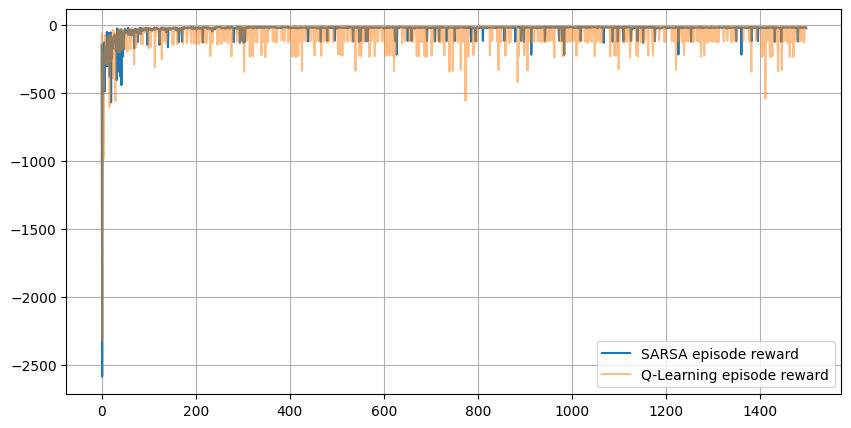

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.grid()
ax.plot(sarsa_rewards, label='SARSA episode reward')
ax.plot(qlearning_rewards, label='Q-Learning episode reward', alpha=0.5)
ax.legend()

## 어? off-policy 인 Q-learning의 보상이 더 높을줄 알았는데...?

off-policy인 Q-learning의 정책이 on-policy 인 SARSA의 보상보다 낮은 결과를 episode reward 를 얻었네요? 이게 무슨일일까요?

> 정답은 0이 아닌 $\epsilon$에 있습니다.

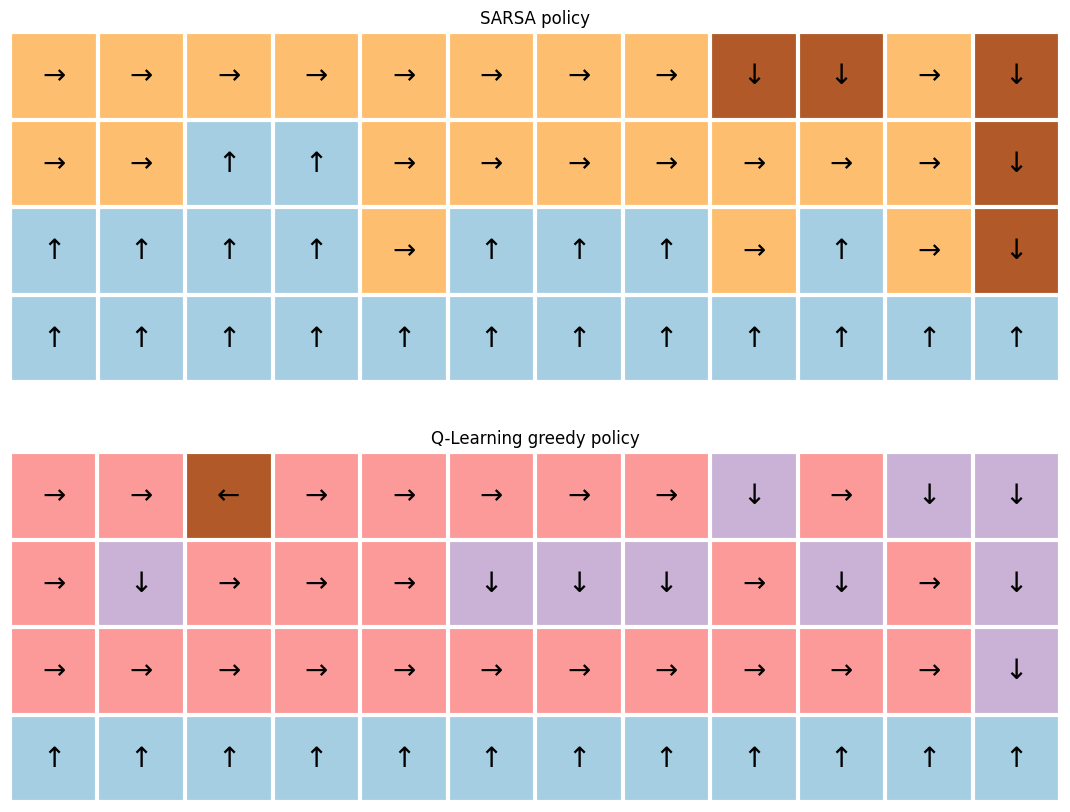

In [13]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
visualize_policy(ax[0], sarsa_agent.q, cliff_env.shape[0], cliff_env.shape[1])
_ = ax[0].set_title("SARSA policy")

visualize_policy(ax[1], q_agent.q, cliff_env.shape[0], cliff_env.shape[1])
_ = ax[1].set_title("Q-Learning greedy policy")